# Qidfa I, Ahmed et al.

### define process data function

In [1]:
def compare_brine_concentrations(dataframe, raw_data, export_path, elemental_masses, literature_cf, original_concentrations = True):
    from chempy.properties.water_density_tanaka_2001 import water_density
    from sigfig import round
    from scipy.constants import milli, kilo
    from matplotlib import pyplot
    import matplotlib

    pandas.set_option('display.max_columns', None)
    pandas.set_option('display.max_rows', None)
    print('raw_data')
    display(raw_data)
    print('processed_data')
    display(dataframe)

    # final effluent concentrations
    final_cf = raw_data['mass_H2O'].iloc[0] / raw_data['mass_H2O'].iloc[-1]
    last_row = dataframe.iloc[-1]
    print('literature_cf', literature_cf)
    print('final_cf', final_cf)

    # feed concentrations
    water_density = water_density()/kilo
    solution_description = 'Ahmed'
    custom_water_parameters = {
        'element': {
            'Ca': {
                'concentration (ppm)':464,
                'reference': ''
            },
            'Mg': {
                'concentration (ppm)':1640,
                'reference':''
            },
            'Na': {
                'concentration (ppm)':11900,
                'reference':''
            },
            'Sr': {
                'concentration (ppm)':4.56,
                'reference':''
            },
            'Cl': {
                'concentration (ppm)':23149,
                'reference':''
            },
            'S(6)': {
                'concentration (ppm)':2787,
                'reference':''
            },
            'Fe': {
                'concentration (ppm)':0.22,
                'reference':''
            },
            'K': {
                'concentration (ppm)':574,
                'reference':''
            }
        },
        'Alkalinity': {
            'value': 111,
            'reference': ''
        }
    }

    def make_molal(elements):
        molals = {}
        for element in elements:
            original_element = element
            element = re.sub('(?:\(\d\))', '', element)
            mass = elemental_masses[element]/milli
            if type(elements[original_element]) is dict:
                ppm_conc = elements[original_element]['concentration (ppm)']
            else:
                ppm_conc = elements[original_element]
            molal_conc = ppm_conc / water_density / mass
            molals[original_element] = float(molal_conc)
            
        return molals

    molals = make_molal(custom_water_parameters['element'])
    literature_molals = make_molal(literature_final_conc)
    
    # final effluent CF for each element
    cfs = {}
    diff_list = []
    labels = []
    for element, final_conc in last_row.iteritems():
        element = re.search('([A-Z][a-z]?(?:\(\d\))?(?=\(mol\/kgw\)))', element).group()
        cfs[element] = {}
        initial_conc = molals[element]

        if original_concentrations:
            if element in literature_elemental_cfs:
                cfs[element]['cf'] = float(final_conc) / initial_conc
                diff = ((cfs[element]['cf'] - literature_elemental_cfs[element]) / literature_elemental_cfs[element]) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff
                
        elif not original_concentrations:
            if element in literature_final_conc:
                predicted_conc = initial_conc * literature_cf
                literature_conc = literature_molals[element]
                diff = ((predicted_conc - literature_conc) / literature_conc) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff

    # define a bar graph of CF error 
    print(cfs)
    labels.append('CF')
    total_cf_error = ((final_cf - literature_cf) / literature_cf * 100)
    diff_list.append(total_cf_error)
    min_diff = min(diff_list) - 5
    max_diff = max(diff_list) + 5

    pyplot.rcParams['figure.figsize'] = (12, 9)
    pyplot.rcParams['figure.dpi'] = 100
    figure, ax = pyplot.subplots()
    bar_graph = ax.bar(labels, diff_list)
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('relative % difference')
    ax.set_ylim(min_diff, max_diff)
    ax.set_xlabel('Element')
    ax.set_title('Elemental difference of ROSSpy from Qifda I, Ahmed et al.')
    diff_list = [round(value, 2, notation = 'sci') for value in diff_list]
    ax.bar_label(bar_graph, diff_list)
    figure.savefig(export_path)

### Experimental conditions

In [3]:
from scipy.constants import nano, milli, day, hour
from chemicals import periodic_table
import os, re

elemental_masses = {}
for element in periodic_table:
    elemental_masses[element.symbol] = element.MW
    
def average(some_list):
    return sum(some_list)/ len(some_list)

# run the ROSS model
# %run ../../../rosspy/ro.py
# ross = ROSSPkg()
import rosspy
ross = rosspy.ROSSPkg(verbose = False)

# water parameters
solution_description = 'Ahmed'
water_characteristics = {
    'element': {
        'Ca': {
            'concentration (ppm)':464,
            'reference': ''
        },
        'Mg': {
            'concentration (ppm)':1640,
            'reference':''
        },
        'Na': {
            'concentration (ppm)':11900,
            'reference':''
        },
        'Sr': {
            'concentration (ppm)':4.56,
            'reference':''
        },
        'Cl': {
            'concentration (ppm)':23149,
            'reference':''
        },
        'S(6)': {
            'concentration (ppm)':2787,
            'reference':''
        },
        'Fe': {
            'concentration (ppm)':0.22,
            'reference':''
        },
        'K': {
            'concentration (ppm)':574,
            'reference':''
        }
    },
    'Alkalinity': {
        'value': 111,
        'reference': ''
    }
}

# literature final effluent concentrations 
literature_final_conc = {
    'Ca': 617,
    'Mg': 2150,
    'Na': 15100,
    'Sr': 7.19,
    'Fe': 0.33,
    'Cl': 30540,
    'K': 767,
    'S(6)': 3931
}
literature_elemental_cfs = {}
for element in literature_final_conc:
    true_element = re.search('([A-Z][a-z]?)', element).group()
    literature_elemental_cfs[element] = literature_final_conc[element]/(water_characteristics['element'][element]['concentration (ppm)'])
literature_cf = average([(literature_elemental_cfs[element]) for element in literature_elemental_cfs])

# general parameters
database_selection = 'pitzer'
simulation = 'brine'
simulation_time = 275

# Execute through all_time


Estimated completion in 8.47 seconds: 2022-01-21 01:52:36.240161 local time.
run_time (s): 5.675444200000001
raw_data


,sim,state,soln,dist_x,time,step,pH,pe,reaction,temp(C),Alk(eq/kgw),mu,mass_H2O,charge(eq),Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw),Anhydrite,d_Anhydrite,Aragonite,d_Aragonite,Arcanite,d_Arcanite,Artinite,d_Artinite,Bischofite,d_Bischofite,Bloedite,d_Bloedite,Brucite,d_Brucite,Burkeite,d_Burkeite,Calcite,d_Calcite,Carnallite,d_Carnallite,Celestite,d_Celestite,Dolomite,d_Dolomite,Epsomite,d_Epsomite,Gaylussite,d_Gaylussite,Glaserite,d_Glaserite,Glauberite,d_Glauberite,Goergeyite,d_Goergeyite,Gypsum,d_Gypsum,Halite,d_Halite,Hexahydrite,d_Hexahydrite,Huntite,d_Huntite,Kainite,d_Kainite,Kieserite,d_Kieserite,Labile_S,d_Labile_S,Leonhardite,d_Leonhardite,Leonite,d_Leonite,Magnesite,d_Magnesite,MgCl2_2H2O,d_MgCl2_2H2O,MgCl2_4H2O,d_MgCl2_4H2O,Mirabilite,d_Mirabilite,Natron,d_Natron,Nesquehonite,d_Nesquehonite,Pentahydrite,d_Pentahydrite,Pirssonite,d_Pirssonite,Polyhalite,d_Polyhalite,Portlandite,d_Portlandite,Schoenite,d_Schoenite,Sylvite,d_Sylvite,Syngenite,d_Syngenite,Thenardite,d_Thenardite,si_Anhydrite,si_Aragonite,si_Arcanite,si_Artinite,si_Bischofite,si_Bloedite,si_Brucite,si_Burkeite,si_Calcite,si_Carnallite,si_Celestite,si_Dolomite,si_Epsomite,si_Gaylussite,si_Glaserite,si_Glauberite,si_Goergeyite,si_Gypsum,si_Halite,si_Hexahydrite,si_Huntite,si_Kainite,si_Kieserite,si_Labile_S,si_Leonhardite,si_Leonite,si_Magnesite,si_MgCl2_2H2O,si_MgCl2_4H2O,si_Mirabilite,si_Natron,si_Nesquehonite,si_Pentahydrite,si_Pirssonite,si_Polyhalite,si_Portlandite,si_Schoenite,si_Sylvite,si_Syngenite,si_Thenardite
3,1,transp,12,0.973667,0.000000,0,7.000000,4.0,16.448128,25.0,1.216293e-09,1.006454e-07,17.378154,-2.113692e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
4,1,transp,12,0.973667,3.946330,1,7.000046,4.0,16.448128,25.0,1.237738e-09,1.006455e-07,17.077058,-2.113692e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
5,1,transp,12,0.973667,7.892659,2,7.000097,4.0,16.448128,25.0,1.261054e-09,1.006455e-07,16.761311,-2.113692e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

processed_data


,Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw)
Time (s),,,,,,,,
3.95E1,2.197194e-14,1.284829e-13,9.862843e-13,NaN,NaN,NaN,NaN,NaN
4.34E1,3.039928e-08,1.779426e-07,1.366242e-06,1.373654e-10,0.000002,7.657589e-08,1.039773e-11,3.874983e-08
4.74E1,1.640909e-02,9.628071e-02,7.396059e-01,7.436185e-05,0.932970,4.145385e-02,5.628743e-06,2.097696e-02
5.13E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
5.52E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
5.92E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
6.31E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
6.71E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
7.10E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02


literature_cf 1.3815465672518445
final_cf 1.370804885703634
{'Ca': {'cf': 1.4131519806019466, '% diff': 6.272693516904902}, 'Mg': {'cf': 1.4226808707094047, '% diff': 8.520773393647612}, 'Na': {'cf': 1.4246378683810696, '% diff': 12.272785653872383}, 'Sr': {'cf': 1.4246397274312617, '% diff': -9.647327439686336}, 'Cl': {'cf': 1.4246397274312534, '% diff': 7.986198593012718}, 'S(6)': {'cf': 0.4755274906321108, '% diff': -66.28605656597067}, 'Fe': {'cf': 1.42458870804874, '% diff': -5.0274194634173295}, 'K': {'cf': 1.4246397274312588, '% diff': 6.615802287554437}}


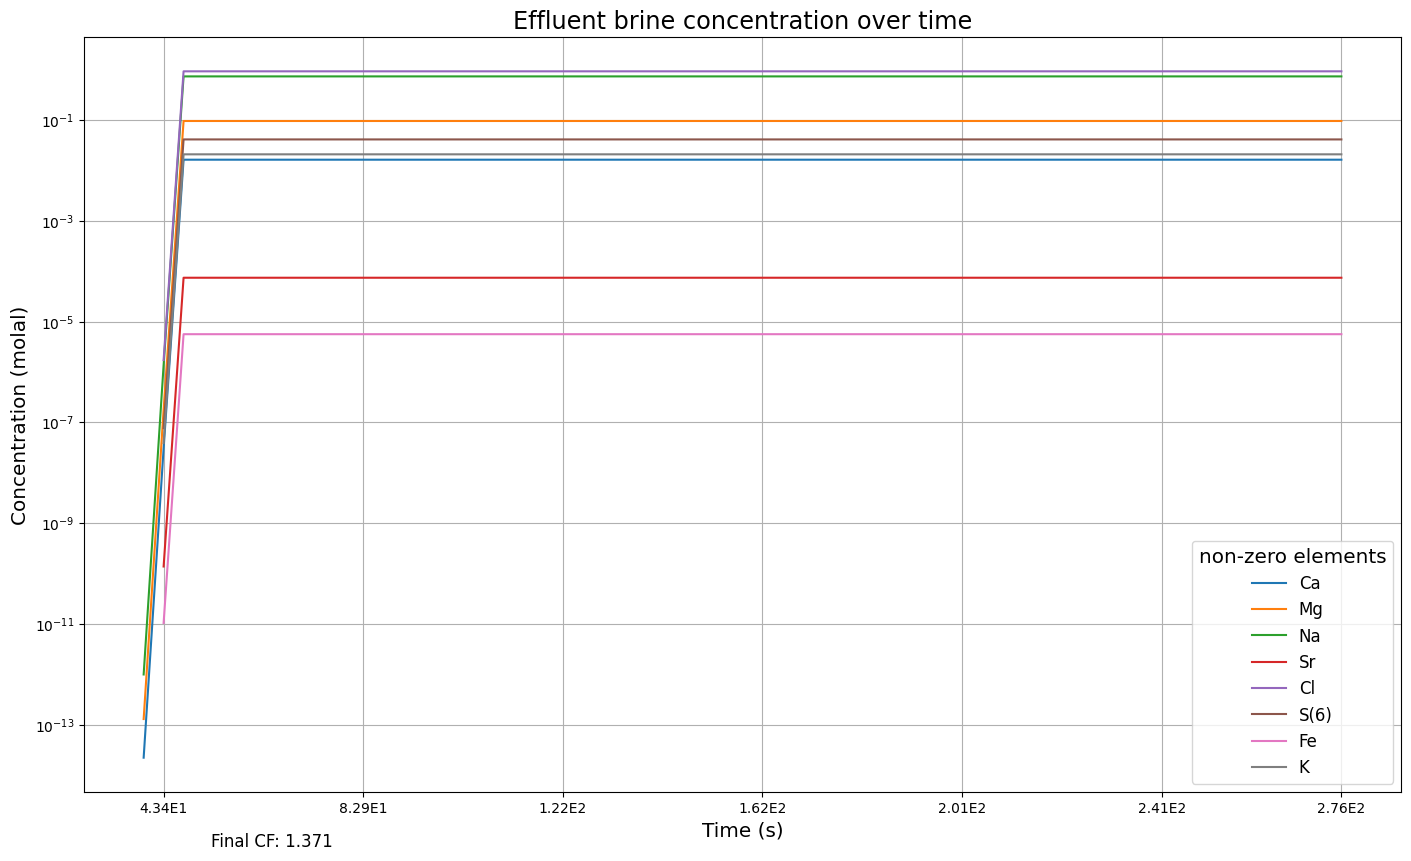

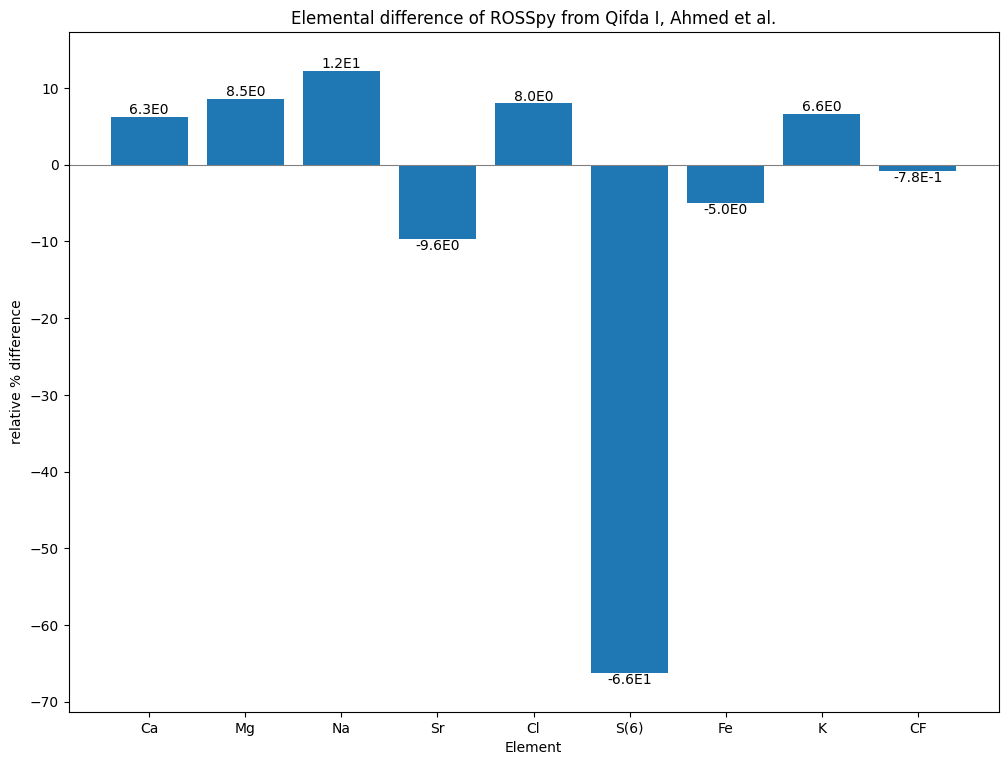

In [7]:
%run ../../../rosspy/ro.py
simulation_name = 'PHREEQ_ionic_concentrations'
simulation_perspective = 'all_time'

# create the input file
ross = ROSSPkg(database_selection, simulation, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name)


# process and export the data
export_path = os.path.join(ross.simulation_path, 'Ahmed_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, elemental_masses, literature_cf)

# Execute through all_time, with improved predictions


Estimated completion in 8.47 seconds: 2022-01-21 01:52:43.492337 local time.
run_time (s): 5.688336199999995
raw_data


,sim,state,soln,dist_x,time,step,pH,pe,reaction,temp(C),Alk(eq/kgw),mu,mass_H2O,charge(eq),Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw),Anhydrite,d_Anhydrite,Aragonite,d_Aragonite,Arcanite,d_Arcanite,Artinite,d_Artinite,Bischofite,d_Bischofite,Bloedite,d_Bloedite,Brucite,d_Brucite,Burkeite,d_Burkeite,Calcite,d_Calcite,Carnallite,d_Carnallite,Celestite,d_Celestite,Dolomite,d_Dolomite,Epsomite,d_Epsomite,Gaylussite,d_Gaylussite,Glaserite,d_Glaserite,Glauberite,d_Glauberite,Goergeyite,d_Goergeyite,Gypsum,d_Gypsum,Halite,d_Halite,Hexahydrite,d_Hexahydrite,Huntite,d_Huntite,Kainite,d_Kainite,Kieserite,d_Kieserite,Labile_S,d_Labile_S,Leonhardite,d_Leonhardite,Leonite,d_Leonite,Magnesite,d_Magnesite,MgCl2_2H2O,d_MgCl2_2H2O,MgCl2_4H2O,d_MgCl2_4H2O,Mirabilite,d_Mirabilite,Natron,d_Natron,Nesquehonite,d_Nesquehonite,Pentahydrite,d_Pentahydrite,Pirssonite,d_Pirssonite,Polyhalite,d_Polyhalite,Portlandite,d_Portlandite,Schoenite,d_Schoenite,Sylvite,d_Sylvite,Syngenite,d_Syngenite,Thenardite,d_Thenardite,si_Anhydrite,si_Aragonite,si_Arcanite,si_Artinite,si_Bischofite,si_Bloedite,si_Brucite,si_Burkeite,si_Calcite,si_Carnallite,si_Celestite,si_Dolomite,si_Epsomite,si_Gaylussite,si_Glaserite,si_Glauberite,si_Goergeyite,si_Gypsum,si_Halite,si_Hexahydrite,si_Huntite,si_Kainite,si_Kieserite,si_Labile_S,si_Leonhardite,si_Leonite,si_Magnesite,si_MgCl2_2H2O,si_MgCl2_4H2O,si_Mirabilite,si_Natron,si_Nesquehonite,si_Pentahydrite,si_Pirssonite,si_Polyhalite,si_Portlandite,si_Schoenite,si_Sylvite,si_Syngenite,si_Thenardite
3,1,transp,12,0.973667,0.000000,0,7.000000,4.0,16.448128,25.0,1.216293e-09,1.006454e-07,17.378154,-2.113692e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
4,1,transp,12,0.973667,3.946330,1,7.000046,4.0,16.448128,25.0,1.237738e-09,1.006455e-07,17.077058,-2.113692e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
5,1,transp,12,0.973667,7.892659,2,7.000097,4.0,16.448128,25.0,1.261054e-09,1.006455e-07,16.761311,-2.113692e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

processed_data


,Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw)
Time (s),,,,,,,,
3.95E1,2.197194e-14,1.284829e-13,9.862843e-13,NaN,NaN,NaN,NaN,NaN
4.34E1,3.039928e-08,1.779426e-07,1.366242e-06,1.373654e-10,0.000002,7.657589e-08,1.039773e-11,3.874983e-08
4.74E1,1.640909e-02,9.628071e-02,7.396059e-01,7.436185e-05,0.932970,4.145385e-02,5.628743e-06,2.097696e-02
5.13E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
5.52E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
5.92E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
6.31E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
6.71E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02
7.10E1,1.640912e-02,9.628089e-02,7.396073e-01,7.436199e-05,0.932972,4.145393e-02,5.628754e-06,2.097700e-02


literature_cf 1.3815465672518445
final_cf 1.370804885703634
{'Ca': {'% diff': 3.8958844740446983}, 'Mg': {'% diff': 5.383086990373269}, 'Na': {'% diff': 8.876848677463245}, 'Sr': {'% diff': -12.380356791816254}, 'Cl': {'% diff': 4.71978220469206}, 'S(6)': {'% diff': -2.0511248300460156}, 'Fe': {'% diff': -7.896895516543714}, 'K': {'% diff': 3.3908382793427325}}


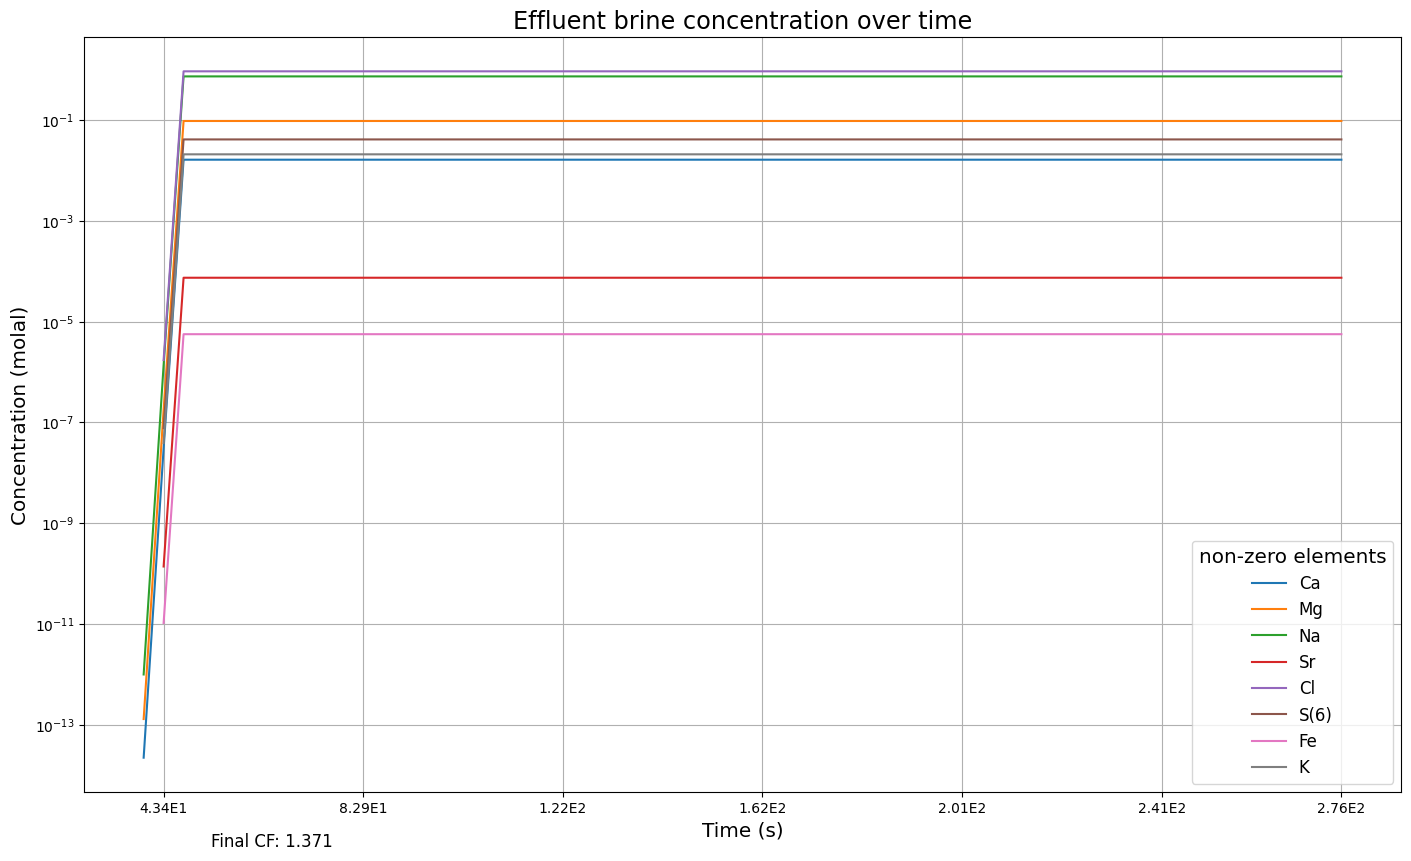

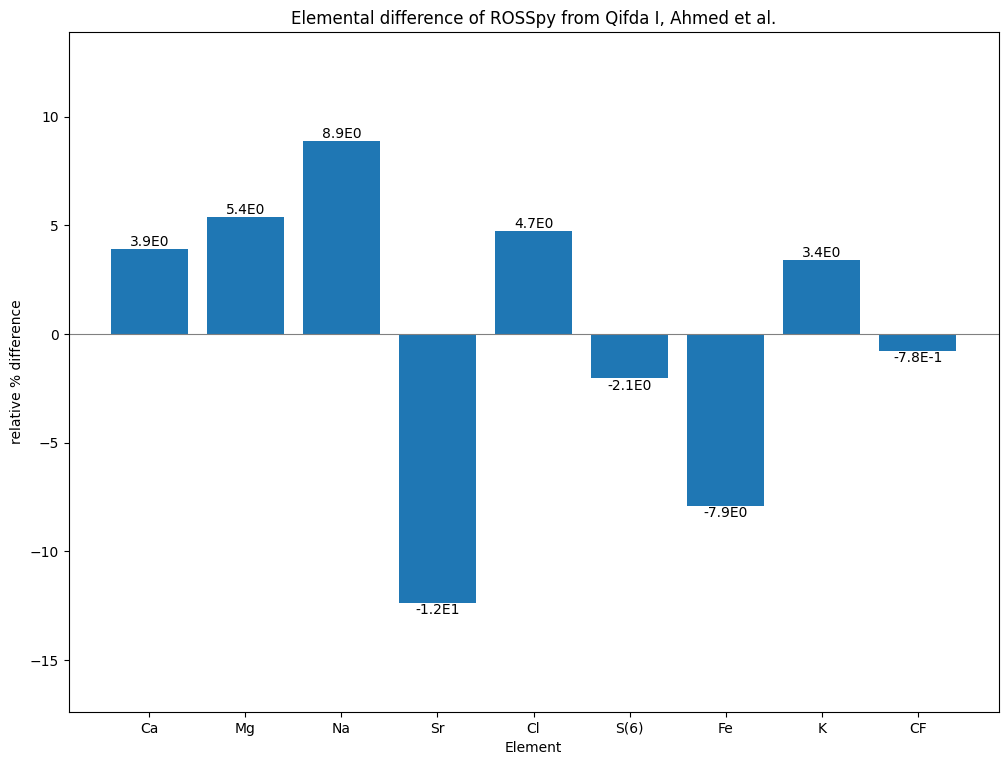

In [8]:
%run ../../../rosspy/ro.py
simulation_perspective = 'all_time'
simulation_name = 'improved_ionic_concentrations'

# create the input file
ross = ROSSPkg(database_selection, simulation, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name)

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Ahmed_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, elemental_masses, literature_cf, False)

## Execute a single module over all_distance


Estimated completion in 8.47 seconds: 2022-01-21 01:52:50.673178 local time.
run_time (s): 5.6606132
raw_data


,sim,state,soln,dist_x,time,step,pH,pe,reaction,temp(C),Alk(eq/kgw),mu,mass_H2O,charge(eq),Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw),Anhydrite,d_Anhydrite,Aragonite,d_Aragonite,Arcanite,d_Arcanite,Artinite,d_Artinite,Bischofite,d_Bischofite,Bloedite,d_Bloedite,Brucite,d_Brucite,Burkeite,d_Burkeite,Calcite,d_Calcite,Carnallite,d_Carnallite,Celestite,d_Celestite,Dolomite,d_Dolomite,Epsomite,d_Epsomite,Gaylussite,d_Gaylussite,Glaserite,d_Glaserite,Glauberite,d_Glauberite,Goergeyite,d_Goergeyite,Gypsum,d_Gypsum,Halite,d_Halite,Hexahydrite,d_Hexahydrite,Huntite,d_Huntite,Kainite,d_Kainite,Kieserite,d_Kieserite,Labile_S,d_Labile_S,Leonhardite,d_Leonhardite,Leonite,d_Leonite,Magnesite,d_Magnesite,MgCl2_2H2O,d_MgCl2_2H2O,MgCl2_4H2O,d_MgCl2_4H2O,Mirabilite,d_Mirabilite,Natron,d_Natron,Nesquehonite,d_Nesquehonite,Pentahydrite,d_Pentahydrite,Pirssonite,d_Pirssonite,Polyhalite,d_Polyhalite,Portlandite,d_Portlandite,Schoenite,d_Schoenite,Sylvite,d_Sylvite,Syngenite,d_Syngenite,Thenardite,d_Thenardite,si_Anhydrite,si_Aragonite,si_Arcanite,si_Artinite,si_Bischofite,si_Bloedite,si_Brucite,si_Burkeite,si_Calcite,si_Carnallite,si_Celestite,si_Dolomite,si_Epsomite,si_Gaylussite,si_Glaserite,si_Glauberite,si_Goergeyite,si_Gypsum,si_Halite,si_Hexahydrite,si_Huntite,si_Kainite,si_Kieserite,si_Labile_S,si_Leonhardite,si_Leonite,si_Magnesite,si_MgCl2_2H2O,si_MgCl2_4H2O,si_Mirabilite,si_Natron,si_Nesquehonite,si_Pentahydrite,si_Pirssonite,si_Polyhalite,si_Portlandite,si_Schoenite,si_Sylvite,si_Syngenite,si_Thenardite
3,1,transp,1,0.042333,0.000000,0,7.000000,4.0,29.726380,25.0,1.216293e-09,1.006454e-07,17.378154,-2.113692e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
4,1,transp,2,0.127000,0.000000,0,7.000000,4.0,27.949068,25.0,1.216293e-09,1.006454e-07,17.378154,-2.113692e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000,-999.999000
5,1,transp,3,0.211667,0.000000,0,7.000000,4.0,26.326525,25.0,1.216293e-09,1.006454e-07,17.378154,-2.113692e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

processed_data


,Ca(mol/kgw),Mg(mol/kgw),Na(mol/kgw),Sr(mol/kgw),Cl(mol/kgw),S(6)(mol/kgw),Fe(mol/kgw),K(mol/kgw)
Distance (m),,,,,,,,
4.23E-2,0.012273,0.071761,0.550859,0.000055,0.694877,0.030875,0.000004,0.015624
1.27E-1,0.012650,0.073991,0.568018,0.000057,0.716523,0.031837,0.000004,0.016110
2.12E-1,0.013027,0.076221,0.585178,0.000059,0.738168,0.032798,0.000004,0.016597
2.96E-1,0.013404,0.078451,0.602337,0.000061,0.759814,0.033760,0.000005,0.017084
3.81E-1,0.013780,0.080681,0.619496,0.000062,0.781459,0.034722,0.000005,0.017570
4.66E-1,0.014156,0.082910,0.636655,0.000064,0.803104,0.035684,0.000005,0.018057
5.50E-1,0.014532,0.085139,0.653814,0.000066,0.824749,0.036645,0.000005,0.018544
6.35E-1,0.014908,0.087368,0.670973,0.000067,0.846394,0.037607,0.000005,0.019030
7.20E-1,0.015284,0.089596,0.688132,0.000069,0.868038,0.038569,0.000005,0.019517


literature_cf 1.3815465672518445
final_cf 1.370804885703634
{'Ca': {'% diff': 3.8958844740446983}, 'Mg': {'% diff': 5.383086990373269}, 'Na': {'% diff': 8.876848677463245}, 'Sr': {'% diff': -12.380356791816254}, 'Cl': {'% diff': 4.71978220469206}, 'S(6)': {'% diff': -2.0511248300460156}, 'Fe': {'% diff': -7.896895516543714}, 'K': {'% diff': 3.3908382793427325}}


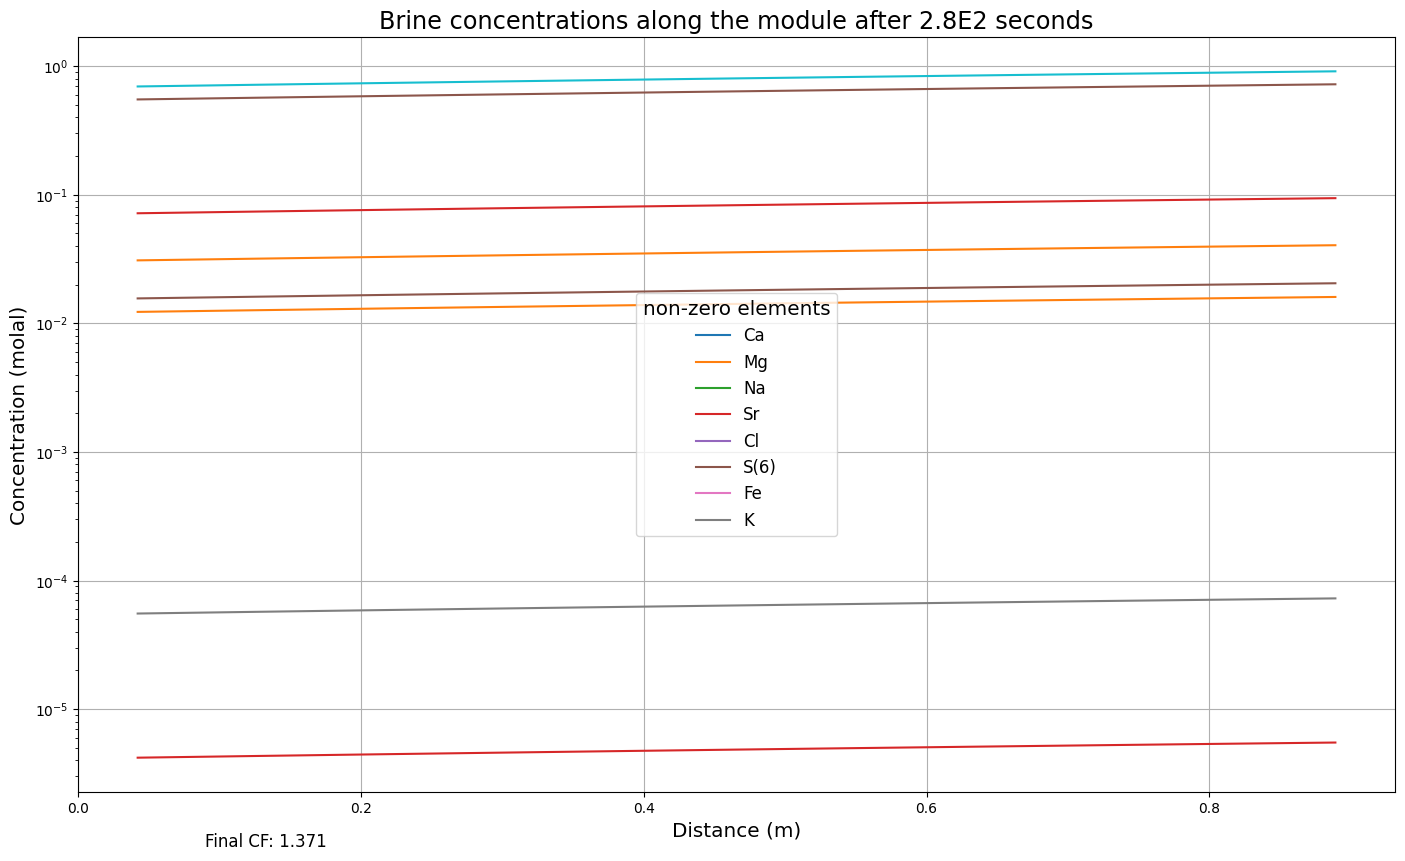

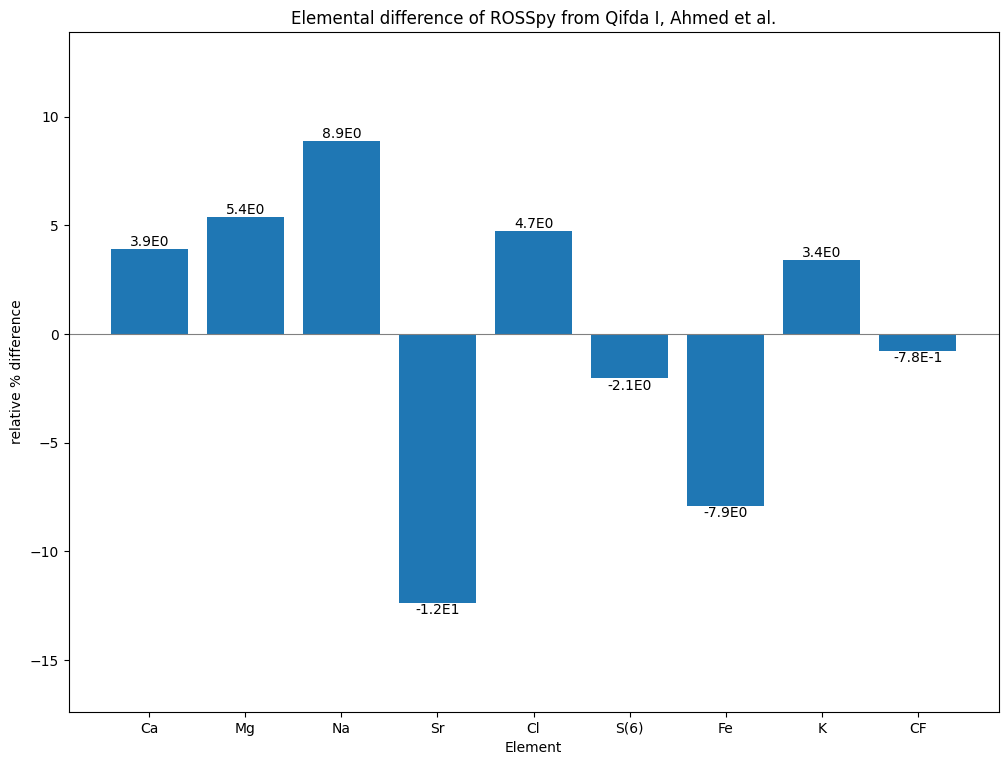

In [9]:
%run ../../../rosspy/ro.py
simulation_perspective = 'all_distance'
simulation_name = 'improved_ionic_concentrations_over_distance'

# create the input file
ross = ROSSPkg(database_selection, simulation, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name)

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Ahmed_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, elemental_masses, literature_cf, False)